## 1.Import Required Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping


2026-01-02 23:05:44.945539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767395145.141485      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767395145.201462      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load Training, Validation, and Test Datasets

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
ds_test=tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing',
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE
                                                    )

ds_train=tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training',
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE
                                                    )

ds_val=tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation',
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE
                                                    )

Found 405 files belonging to 3 classes.


I0000 00:00:1767395160.965698      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767395160.966306      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 3251 files belonging to 3 classes.
Found 416 files belonging to 3 classes.


## 3. Display Class Names

In [3]:
class_names=ds_train.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

## 4. Visualize Sample Training Images

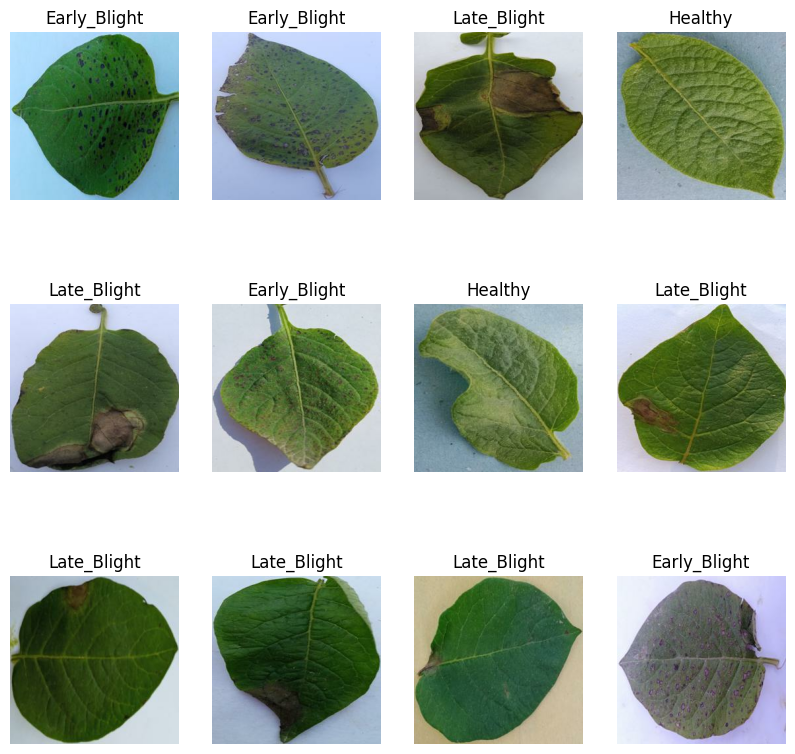

In [4]:
plt.figure(figsize=(10,10))
for image_batch,image_labels in ds_train.take(1):
    for i in range(12):
     ax=plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype('uint8'))
     plt.title(class_names[image_labels[i]])
     plt.axis('off')


In [5]:
print(f"training dataset: {len(ds_train)}")
print(f"test dataset: {len(ds_test)}")
print(f"validation dataset: {len(ds_val)}")


training dataset: 102
test dataset: 13
validation dataset: 13


## 5. Optimize Dataset Loading Performance

In [6]:
ds_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## 6. Preprocessing & Data Augmentation

### 6.1 Rescaling and Resizing

In [7]:
resize_and_rescale=tf.keras.Sequential([
    layers.Rescaling(1.0/255),
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE)
])

### 6.2 Data Augmentation

In [8]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
     layers.RandomRotation(0.5),
     layers.RandomZoom(0.2),
     layers.RandomContrast(0.3),
     layers.RandomBrightness(0.2)

])

In [9]:
augmented_ds = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y))

ds_train = ds_train.concatenate(augmented_ds)


In [10]:
len(ds_train)

204

## 7. Model Architecture (CNN)

In [11]:
n_classes=3
model=tf.keras.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation=('relu')),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes,activation='softmax') # softmax = Multi Classification & Categorical Crossentropy
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 8. Compile the Model

In [12]:
model.compile(
          optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
          ,metrics=['accuracy'])

## 9. Training the Model

In [13]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',   
    patience=5,           
    restore_best_weights=True 
)


history=model.fit(
    ds_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=ds_val,
    callbacks=[early_stopping]
)


Epoch 1/10


I0000 00:00:1767395173.876194      69 service.cc:148] XLA service 0x7a437810a100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767395173.877019      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767395173.877044      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767395174.357387      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/204 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3613 - loss: 1.0969

I0000 00:00:1767395179.561231      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 ━━━━━━━━━━━━━━━━━━━━ 95s 424ms/step - accuracy: 0.4148 - loss: 1.0614 - val_accuracy: 0.5312 - val_loss: 0.9758
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 81s 398ms/step - accuracy: 0.5841 - loss: 0.9137 - val_accuracy: 0.7764 - val_loss: 0.5528
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 79s 391ms/step - accuracy: 0.8096 - loss: 0.5344 - val_accuracy: 0.8678 - val_loss: 0.3322
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 80s 396ms/step - accuracy: 0.8781 - loss: 0.3532 - val_accuracy: 0.9279 - val_loss: 0.1976
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 81s 400ms/step - accuracy: 0.9181 - loss: 0.2511 - val_accuracy: 0.8918 - val_loss: 0.3026
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 82s 402ms/step - accuracy: 0.9463 - loss: 0.1854 - val_accuracy: 0.9591 - val_loss: 0.1363
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 82s 402ms/step - accuracy: 0.9493 - loss: 0.1581 - val_accuracy: 0.9736 - val_loss: 0.0868
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 83s 407ms/step - accuracy: 0.9628 - loss: 0.1310 - val

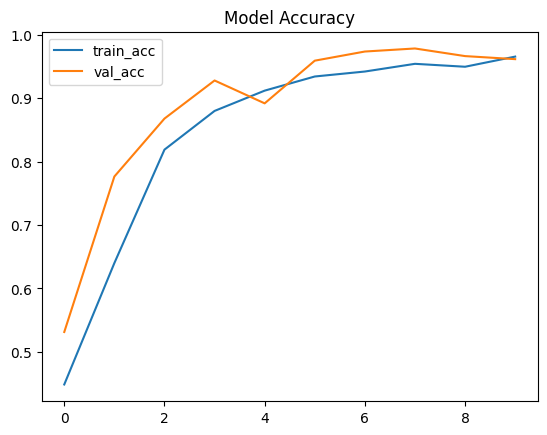

In [14]:
# --- PLOT TRAINING PERFORMANCE ---
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Model Accuracy')
plt.show()

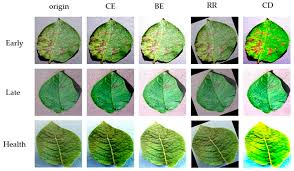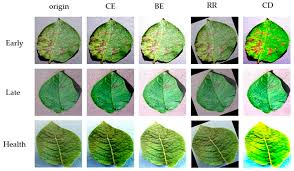

In [15]:
test_loss, test_acc =model.evaluate(ds_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9586 - loss: 0.0970
Test Accuracy: 0.9679
Test Loss: 0.0877
